## Solving Minimum Independent Set using Quantum Variational Algorithms

In this notebook, we will solve the Minimum Independent Set problem using Quantum Variational algorithms, more specifically, QAOA and ADAPT-QAOA.

### Importing required functions

In [1]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [2]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA

In [3]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

### Generating a random graph

We will test the algorithms on a random graph instance. The random graph is a graph on $8$ nodes and between any two nodes, an edge is present with probability $0.5$.

To generate the graph, we will use the custom `generate_random_graph` method which will return a rustworkx `Graph` instance. Then, using the custom `get_hamiltonian_from_graph` method, we will construct the cost Hamiltonian $H_p$ corresponding to the quadratic program that solves the minimum independent set probelm.

In [4]:
G = generate_random_graph(8, 0.3)

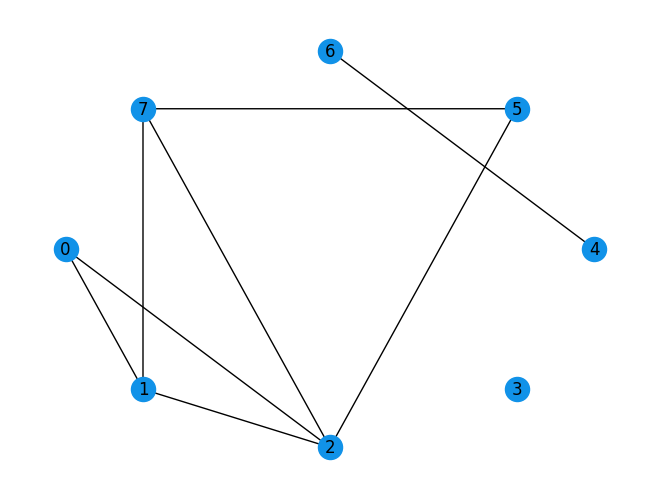

In [5]:
mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=False, node_color="#1192E8")

In [6]:
cost_hamiltonian = get_hamiltonian_from_graph(G)
print(cost_hamiltonian)

SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIIIZZ', 'IIIIIZZI', 'ZIIIIIZI', 'IIIIIZIZ', 'IIIIIZZI', 'IIZIIZII', 'ZIIIIZII', 'IZIZIIII', 'IIZIIZII', 'ZIZIIIII', 'IZIZIIII', 'ZIIIIIZI', 'ZIIIIZII', 'ZIZIIIII'],
              coeffs=[-3.+0.j, -5.+0.j, -7.+0.j,  1.+0.j, -1.+0.j, -3.+0.j, -1.+0.j, -5.+0.j,
  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,
  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


### Brute Force Solution

As the first approach, we use the bruteforce approach to obtain the optimal assignment for the generated graph instance. This is done by computing the expectation value of the cost Hamiltonian for each of the $2^8 = 256$ assignments. The assignments corresponding to the smallest expectation value are valid optimal assignments. The optimal assignments obtained using the brute force approach will be used to compare the performance of the quantum algorithms.

We use the custom `BFMinimizeCombinatorial` class to identify the optimal assignments. A `BFMinimizeCombinatorial` instance `brute` is created using a cost Hamiltonian $H_p$ as an input. The `.run()` method uses the `StatevectorEstimator` primitive to compute the expectation value $\langle x \lvert H_p \lvert x \rangle$ for each of the $256$ assignments $x$. The minimum value of the expectation values $C_m$ is called the optimal value and the assignments $x$ such that $\langle x \lvert H_p \lvert x \rangle = C_m$ are optimal assignments.


Note that depending on the graph instances, it is possible to have more than one optimal assignment.

In [7]:
brute = BFMinimizeCombinatorial(cost_hamiltonian)
brute.run()
print(f"The minimum cost of the Hamiltonian is {brute.optimal_value}.")
print(f"The list of optimal assignments is {brute.optimal_assignments}.")

The minimum cost of the Hamiltonian is -16.0.
The list of optimal assignments is ['00111001', '00111010', '01101001', '01101010', '10011001', '11001001'].


### Using QAOA

In this section, we use QAOA to obtain the optimal assignments. For this, we use the custom `QAOA` class. We create a `QAOA` class using the cost Hamiltonian $H_p$ and use `num_layers` to set the number of alternating layers of the ansatz as $7$. In addition, more parameters like `mixer_hamiltonian`, `reference_circuit`, 'anzatz', and 'optimizer' can be provided as arguments during the class instantiation or can be set after creating a class instance. 

The `.run()` method is used to obtain the minimum energy of the cost Hamiltonian that the optimizer converges to, called optimal value, and it corresponding ansatz parameters, called optimal parameters. If `mixer_hamiltonian` is not provided during the class instantiation or not set after creating an instance, the Hamiltonian $H_m = \sum_i X_i$ is used as the mixer Hamiltonian. If 'estimator' is not set when the `.run()` method is called, the `StatevectorExtimator` primitive is used for estimating the expectation values

In [8]:
qaoa = QAOA(cost_hamiltonian, num_layers=7)
qaoa.run()
print(f"The minimum cost of the Hamiltonian obtained using QAOA with 7 layers is {qaoa.optimal_value}.")

Estimator not provided. Setting StatevectorEstimator as the estimator.
Mixer Hamiltonian is not provided. Using sum_i X_i as the mixer Hamiltonian.
The minimum cost of the Hamiltonian obtained using QAOA with 7 layers is -13.076230887388764.


In [9]:
optimal_qaoa_circuit = qaoa.ansatz.copy()
optimal_parameters = qaoa.optimal_parameters
optimal_qaoa_circuit.measure_all()
optimal_qaoa_circuit.assign_parameters(optimal_parameters, inplace=True)

In [10]:
def get_top_counts(counts, position):
    counts_dict = counts.copy()
    top_counts = []
    for i in range(position):
        max_item = max(counts_dict, key=counts_dict.get)
        top_counts.append(max_item)
        del counts_dict[max_item]

    return top_counts

In [11]:
qaoa_assignment_job = sampler.run([(optimal_qaoa_circuit)], shots=8000)
qaoa_assignment_data = qaoa_assignment_job.result()[0].data
counts = qaoa_assignment_data.meas.get_counts()

solution_candidates = top_k_counts(counts, 5)
print(f"The solution candidates obtained using QAOA is {solution_candidates}.")

The solution candidates obtained using QAOA is ['01101001', '00111001', '00110001', '01100001', '01101000'].


### Using ADAPT-QAOA

Next, we will try to solve the maximum independent set problem using ADAPT-QAOA. ADAPT-QAOA is a variant of QAOA that borrows ideas from ADAPT-VQE. 

The mixer Hamiltonian $H_m$ for QAOA is a single fixed operator that does not commute with the problem Hamiltonian $H_p$. In our case, we use the mixer Hamiltonian $H_m = \sum_i X_i$. The QAOA ansatz consists of alternating layers of $H_m$ and $H_p$. ADAPT-QAOA differes from QAOA in that the mixer Hamiltonian used in different layers need not be the same. ADAPT-QAOA uses a mixer pool that contains multiple mixer Hamiltonians. As it constructs the ansatz, for each layer, it adaptively chooses the mixer Hamiltonian by choosing the Hamiltonian in the mixer pool that has the largest gradient with respect to the cost Hamiltonian and the current ansatz.

For our case, we use three different mixer pools: (i) the QAOA mixer pool $P_Q$, (ii) the single Pauli mixer pool $P_S$, and (iii) the two-Pauli mixer pool $P_D$. The QAOA mixer pool $P_Q$ contains only a single mixer Hamiltonian $\sum_i X_i$. This effectively reduces the ADAPT-QAOA to naive QAOA. The single Pauli mixer pool is the set $P_S = \{X_i, Y_i : i\in [n]\}\cup \{\sum_i X_i, \sum_i Y_i\}$. The two-Pauli mixer pool $P_D$ is the set $P_D = \{U_iV_j : i, j(\neq i)\in [n], U,V\in \{X, Y, Z\}\}\cup P_S$.

We use the `AdaptQAOA` class for ADAPT-QAOA. An instance of `AdaptQAOA` is created using the cost Hamiltonian as the problem Hamiltonian and we set the number of layers to $7$. One could either provide a mixer pool directly or just provide the mixer pool type which will be used to construct the mixer pools explained above. The `.run()` method runs the ADAPT-QAOA optimization. If an estimator primitive is not provided, the `StatevectorEstimator` is used for estimating the expectation values.

First, we run the ADAPT-QAOA optimization using the single Pauli mixer pool.

In [12]:
adapt_qaoa_single = AdaptQAOA(
    problem_hamiltonian = cost_hamiltonian,
    max_num_layers = 7,
    mixer_pool_type = 'single'
)
adapt_qaoa_single.run()

The estimator is not provided. Using StatevectorEstimator for estimation.
The optimizer is set to COBYLA since optimizer is not provided.


In [13]:
print(f"The minimum cost obtained using ADAPT-QAOA with single Pauli mixer pool is {adapt_qaoa_single.optimal_value}")

The minimum cost obtained using ADAPT-QAOA with single Pauli mixer pool is -13.486080933030655


In [14]:
optimal_adapt_qaoa_single_circuit = adapt_qaoa_single.optimal_ansatz.copy()
optimal_parameters = adapt_qaoa_single.optimal_parameters
optimal_adapt_qaoa_single_circuit.measure_all()
optimal_adapt_qaoa_single_circuit.assign_parameters(optimal_parameters, inplace=True)

In [15]:
adapt_qaoa_single_job = sampler.run([(optimal_adapt_qaoa_single_circuit)], shots=8000)
adapt_qaoa_single_data = adapt_qaoa_single_job.result()[0].data
counts = adapt_qaoa_single_data.meas.get_counts()

adapt_qaoa_single_candidate_solutions = top_k_counts(counts, 5)
print(f"The list of candidate solutions obtained using ADAPT-QAOA with single Pauli mixer pool is {adapt_qaoa_single_candidate_solutions}.")

The list of candidate solutions obtained using ADAPT-QAOA with single Pauli mixer pool is ['01001100', '00011100', '11001001', '01101001', '01101010'].


Now, we run the ADAPT-QAOA using the two-Pauli mixer pool.

In [16]:
adapt_qaoa_double = AdaptQAOA(
    problem_hamiltonian = cost_hamiltonian,
    max_num_layers = 7,
    mixer_pool_type = 'double'
)
adapt_qaoa_double.run()

The estimator is not provided. Using StatevectorEstimator for estimation.
The optimizer is set to COBYLA since optimizer is not provided.


In [17]:
print(f"The minimum cost obtained using ADAPT-QAOA with two-Pauli mixer pool is {adapt_qaoa_double.optimal_value}")

The minimum cost obtained using ADAPT-QAOA with two-Pauli mixer pool is -13.436085251232143


In [18]:
optimal_adapt_qaoa_double_circuit = adapt_qaoa_double.optimal_ansatz.copy()
optimal_parameters = adapt_qaoa_double.optimal_parameters
optimal_adapt_qaoa_double_circuit.measure_all()
optimal_adapt_qaoa_double_circuit.assign_parameters(optimal_parameters, inplace=True)

In [19]:
adapt_qaoa_double_job = sampler.run([(optimal_adapt_qaoa_double_circuit)], shots=8000)
adapt_qaoa_double_data = adapt_qaoa_double_job.result()[0].data
counts = adapt_qaoa_double_data.meas.get_counts()

adapt_qaoa_double_candidate_solutions = top_k_counts(counts, 5)
print(f"The candidate solutions obtained using ADAPT-QAOA with two-Pauli mixer pool is {adapt_qaoa_double_candidate_solutions}.")

The candidate solutions obtained using ADAPT-QAOA with two-Pauli mixer pool is ['00011100', '00111001', '01001100', '00111010', '10011001'].


### Plotting how cost changes as the number of layers increase

In order to compare between $P_S$ and $P_D$, we plot the change in the minimun cost as the number of layers are increased

In [20]:
single_cost_list = adapt_qaoa_single.cost_list
double_cost_list = adapt_qaoa_double.cost_list

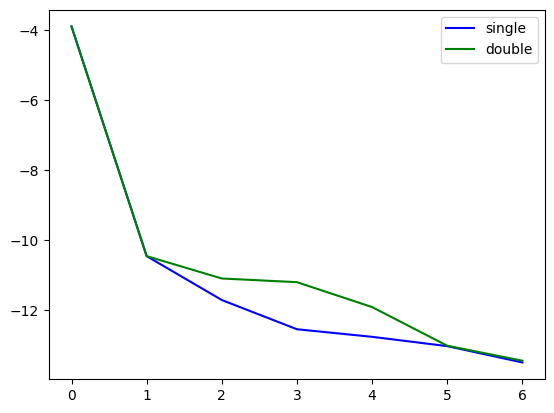

In [21]:
import matplotlib.pyplot as plt

plt.plot(single_cost_list, color='b')
plt.plot(double_cost_list, color='g')

plt.legend(['single', 'double'])